<a href="https://colab.research.google.com/github/fernanda0402/Doutorado/blob/main/GP_gamma_f_sigma_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Bibliotecas:

import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy.interpolate as interp
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.optimize import curve_fit
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pyccl

In [3]:
import pyccl as ccl

In [ ]:
!pip install git+https://github.com/JCGoran/GaPP@feature/python3#GaPP
from gapp import gp, covariance
from numpy import loadtxt, savetxt

Vamos reconstruir os dados de $f\sigma_8$.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Optimized hyperparameters:
theta = [0.32366714 4.68947793]


<ipython-input-52-12da56194f50>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')


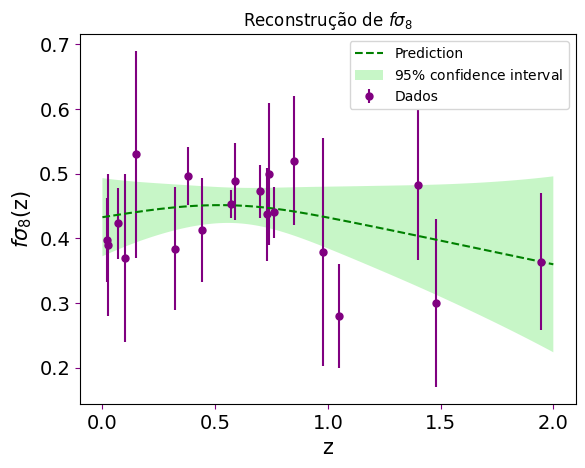

In [52]:
# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/fsig8_data.csv', delimiter=', ')

z_dados = data[:, 0]

fs8_dados = data[:, 1]

sig_fs8 = data[:, 2]

# nomeando
x_gapp = z_dados
y_gapp = fs8_dados
e = sig_fs8

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = 0
xmax = 2.0
nstar = 1000

# initial values of the hyperparameters
initheta = [0.4, 0.1]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar),
                       covfunction=covariance.Matern32)

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta, grad='False')

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('$f\sigma_8$(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstrução de $f\sigma_8$')
plt.show()

# salvando os dados reconstruídos

H = xi, y_pred, sigma
np.savetxt('fs8_recon.dat', np.transpose(H), delimiter='\t')
#from google.colab import files
#files.download("fs8_recon.dat")

Vamos fazer a primeira derivada usando o GaPP de $f\sigma_8$.


Optimized hyperparameters:
theta = [0.32366714 4.68947793]


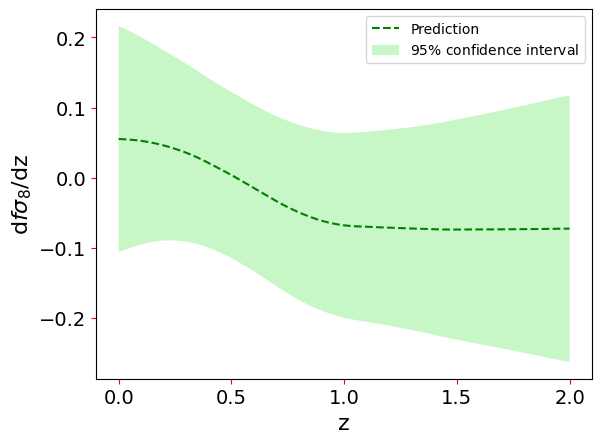

In [51]:
from gapp import dgp # dgp calcula a primeira, segunda e terceira derivada

# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/fsig8_data.csv', delimiter=', ')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

xmin = 0
xmax = 2.0
nstar = 1000

# initial values of the hyperparameters
initheta = [0.4, 0.1]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar),
                       covfunction=covariance.Matern32)

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta, grad='False')

# the second and third derivatives use g.d2gp() and g.d3gp()

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma


# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('d$f\sigma_8$/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

# salvando os dados reconstruídos

dH = xi, y_pred, sigma
np.savetxt('dfs8_recon.dat', np.transpose(dH), delimiter='\t')
#from google.colab import files
#files.download("dfs8_recon.dat")

Porém, o que realmente queremos plotar é a razão $\frac{1}{f\sigma_8(z)} \frac{df\sigma_8}{dz}$.

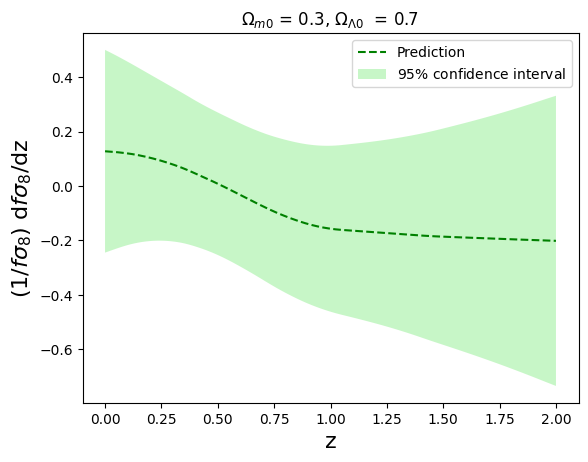

In [53]:
# baixando e nomeando dados
fs8z = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/fs8_recon.dat', delimiter='\t')

z_dgapp = fs8z[:, 0]
fs8_dgapp = fs8z[:, 1]

efs8 = fs8z[:, 2]

dfs8z = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/dfs8_recon.dat', delimiter='\t')

dfs8 = dfs8z[:, 1]

edfs8 = dfs8z[:, 2]

df_fs8 = dfs8 / fs8_dgapp

sigma_ffs8 = np.sqrt(((df_fs8) ** 2) * (((efs8 / fs8_dgapp) ** 2) + ((edfs8 / dfs8) ** 2)))



# PLOTE
plt.plot(z_dgapp, df_fs8, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dgapp, z_dgapp[::-1]]),
         np.concatenate([df_fs8 - 1.9600 * sigma_ffs8,
                        (df_fs8 + 1.9600 * sigma_ffs8)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$f\sigma_8$) d$f\sigma_8$/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Vamos reconstruir os dados de $H(z)$


Optimized hyperparameters:
theta = [134.94426242   1.98775665]


<ipython-input-54-271e207d8f2e>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')


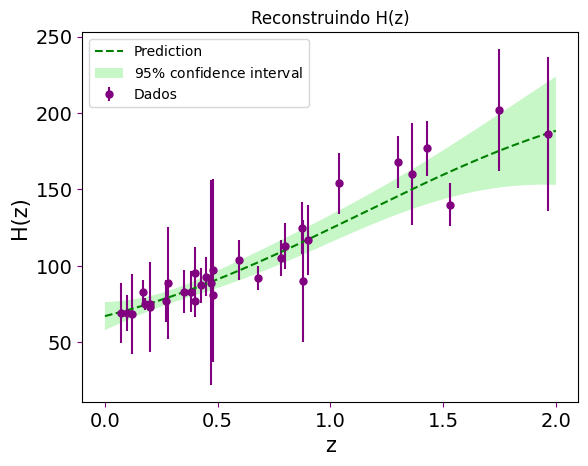

In [54]:
# baixando os dados
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/CC_Hz_data.csv', delimiter=', ')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = 0
xmax = 2.0
nstar = 1000

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
#plt.plot(z, h_1, color='red', label='$\Lambda$CDM')
plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo H(z)')
plt.show()

# salvando os dados reconstruídos

H = xi, y_pred, sigma
np.savetxt('hz_recon_2.dat', np.transpose(H), delimiter='\t')
#from google.colab import files
#files.download("hz_recon_2.dat")

Vamos fazer a primeira derivada de H usando o GaPP.


Optimized hyperparameters:
theta = [134.94426242   1.98775665]


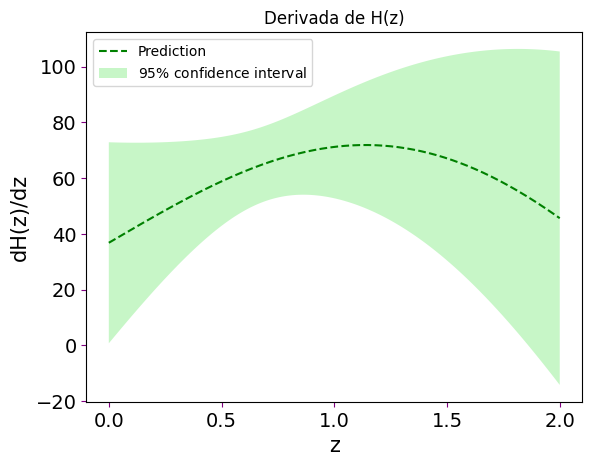

In [55]:
from gapp import dgp # dgp calcula a primeira, segunda e terceira derivada

# baixando os dados reconstruídos de H
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/CC_Hz_data.csv', delimiter=', ')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = 0
xmax = 2.0
nstar = 1000

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

# the second and third derivatives use g.d2gp() and g.d3gp()

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma



# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('dH(z)/dz', fontsize=15)
plt.legend(loc='best')
plt.title('Derivada de H(z)')
plt.show()

# salvando os dados reconstruídos

dH = xi, y_pred, sigma
np.savetxt('dhz_recon_newz_2.dat', np.transpose(dH), delimiter='\t')
#from google.colab import files
#files.download("dhz_recon_newz_2.dat")

Porém, o que realmente queremos plotar é a razão $\frac{1}{H(z)} \frac{dH}{dz}$.

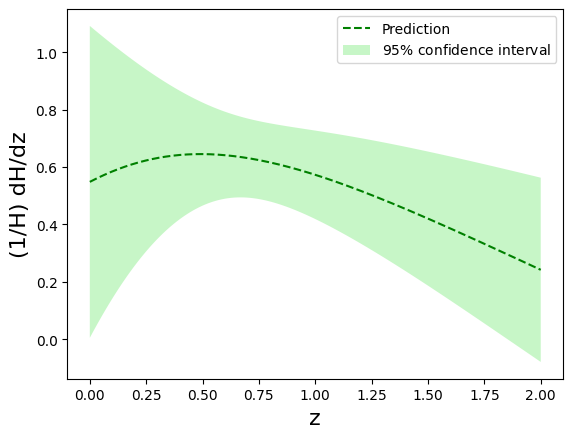

In [56]:
# baixando e nomeando dados reconstruídos de H
hz = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/hz_recon_2.dat', delimiter='\t')

z_hz = hz[:, 0]
h_hz = hz[:, 1]

ehz = hz[:, 2]

# baixando e nomeando dados reconstruídos da derivada de H
dhz = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/dhz_recon_newz_2.dat', delimiter='\t')

z_dhz = dhz[:, 0]

dh = dhz[:, 1]

edh = dhz[:, 2]

dh_h = dh / h_hz  # H'/H

sigma_H = np.sqrt(((dh_h) ** 2) * (((ehz / h_hz) ** 2) + ((edh / dh) ** 2)))


# PLOTE
plt.plot(z_dhz, dh_h, color='green', label='Prediction', linestyle="--")
#plt.plot(z, dh_1, color='red', label='$\Lambda$CDM')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([dh_h - 1.9600 * sigma_H,
                        (dh_h + 1.9600 * sigma_H)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Usaremos o que obtivemos de $H'/H$ para plotar $\frac{\Omega_m '}{\Omega_m}$.

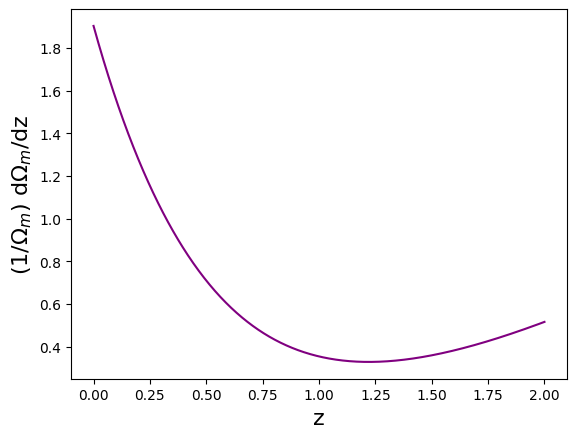

In [57]:
# definindo Om'/Om

dOm_Om = (3/(1+z_dhz)) - (2*dh_h)   #dh_h vem da reconstrução dos dados

eOm = np.sqrt( (2*sigma_H)**2 )

plt.plot(z_dhz, dOm_Om, color='purple')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.show()

Abaixo, temos os plots referentes ao modelo $\Lambda$CDM.

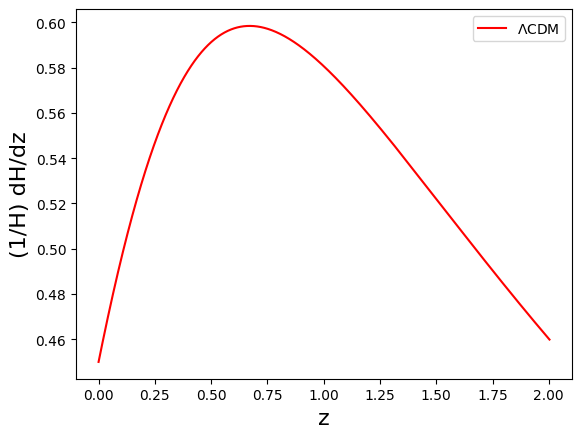

In [58]:
# constantes
Om0 = 0.30
O_L0 = 1 - Om0
h0 = 70 #km/s/Mpc

# MODELO LCDM
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649)


a = np.linspace(0.333, 1, 1000)  # fator de escala

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

h_1 = h0*(np.sqrt(Om0*((1+z)**3) + O_L0 ))

# derivada de H

dh_lcdm = ( (3/2)*h0*Om0*((1+z)**2) )/(np.sqrt(Om0*((1+z)**3) + O_L0 ))

dh_1 = ( (3/2)*Om0*((1+z)**2) )/(Om0*((1+z)**3) + O_L0 ) # H'/H

# plote

plt.plot(z, dh_1, color='red', label='$\Lambda$CDM')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

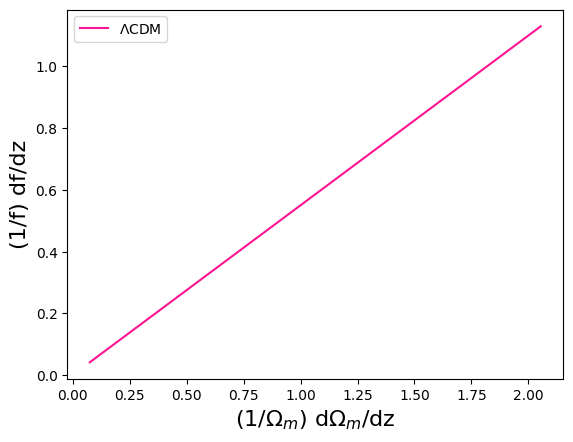

In [59]:
# definindo O_m
Om = (Om0*(a**(-3)))/(Om0*(a**(-3)) + 1 - Om0)
Om0 = 0.315
sigOm0 = 0.007
O_L0 = 1 - Om0
gamma = 0.55

# definindo f conforme linder
f_linder = Om ** gamma

# derivada de f
derivada_flinder = ( (3 * gamma * O_L0)/( (1+z) * (Om0 * ((1+z)**3) + O_L0) ) )  # aqui já é f'/f

# Om'/Om

Omega_m = ccl.background.omega_x(cosmo, a, 'matter')
dOmega_m = np.gradient(Omega_m, z)
dOmega_new = dOmega_m / Omega_m

# PLOTE

plt.plot(dOmega_new, derivada_flinder, color='deeppink', label='$\Lambda$CDM')

# legenda, label e título
plt.xlabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend()
plt.show()